# Лабораторная работа 7


## Системы ОДУ (жесткий вариант)

In [1]:
import numpy as np                # импорт бибилиотеки numpy
import matplotlib.pyplot as plt   # импорт модуля matplotlib.pyplot
import scipy.integrate as integrate # импорт модуля численного интегрирования
import sympy as sym
import scipy as sp
import scipy.optimize as op
import pandas as pd
import copy
import numbers
import math
from scipy.optimize import fsolve

import os
import sys
import git
repo = git.Repo('.', search_parent_directories=True)
library_dir = repo.working_tree_dir + '/lib'
sys.path.insert(0, library_dir)

import miptlib as mipt

# Create directory for generated .tex and .pdf
if not os.path.exists('gen'):
    os.mkdir('gen')

## Полезные вещи

In [2]:
def partial(f, x, var_index, h):
    dim = len(x)
    assert var_index < dim, "Index of variable is greater than dimensity."

    vec_h = np.zeros(dim)
    vec_h[var_index] = h

    return (f(x+vec_h) - f(x-vec_h)) / (2*h)

def getJacobi(f, x, h):
    dim = len(f(x))
    assert dim == len(x), "f and x must be of same size."
    J = np.zeros((dim, dim))

    for i in range(dim):
        for j in range(dim):
            J[i][j] = partial(lambda x: f(x)[i], x, j, h[i])

    return J

def solveSystemNewton(f, x0, n_iter, precision, bl, tr):
    assert precision > 0, "Precision must be positive."
    dim = len(f(x0))
    assert len(x0) == dim and len(bl) == dim and len(tr) == dim, "f, x0, bl and tr must be of same size."
    h = [np.min([np.abs(x0[i] - bl[i]), np.abs(x0[i] - tr[i])]) for i in range(dim)]
    x = x0

    diff = []
    for i in range(n_iter):
        assert np.all(bl < x) and np.all(x < tr), f"Gone out of bounds on iter {i}. Diff: {diff}."
        old_x = x
        x = x - np.matmul(np.linalg.inv(getJacobi(f, x, h)), f(x))
        d = np.abs(x - old_x)
        h = d
        d_norm = np.linalg.norm(d, ord=np.inf)
        diff.append(d_norm)
        if d_norm < precision:
            break

    return x, diff

### Задача:

Решить системы ОДУ следующими классами методов:

0) Попробовать использовать для решения один из методов 3 или 4 порядка лабы 6.
1) Неявный метод Рунге-Кутта 3 порядка и выше (можно двух стадийный метод найти) 
2) Неявный метод Адамса или ФДН (методы Гира) 3 порядка и выше (внимание разгонный участок!) 
3) метод Розенброка-Ваннера 2 и 3 порядка или выше (внимание автономная или неавтономная система ОДУ!)
4) * методы Гира в представлении Нордсика 

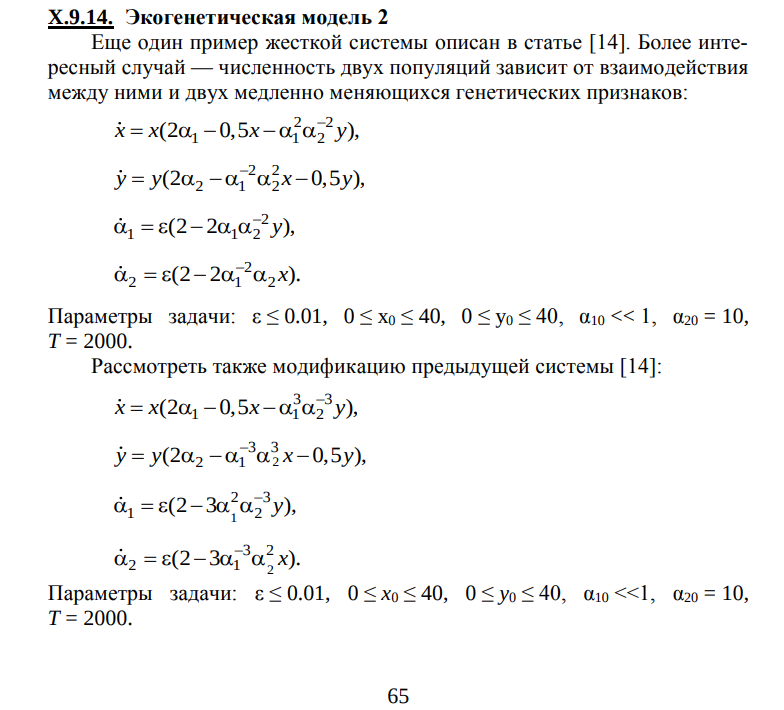

### Исходные данные:

In [3]:
t_begin = 0
t_end = 300
T = 2000
y0 = np.array([4, 10, 0.001, 10])
def f(t, vec, e):
    x, y, a1, a2 = vec
    result = [
        x * (2*a1 - 0.5*x - a1**3 * a2**(-3) * y),
        y * (2*a2 - a1**(-3) * a2**3 * x - 0.5*y),
        e * (2 - 2*a1**2 * a2**(-3) * y),
        e * (2 - 2*a1**(-3) * a2**2 * x)
    ]
    
    return np.array(result)

Epsilon = 0.001

# lab6 task test
# t_begin = 0
# t_end = 100
# y0 = np.array([2, 0])
# def f(t, vec, e):
#     x, z = vec
#     result = [
#         z,
#         e * (1 - x**2) * z - x
#     ]

#     return np.array(result)


In [4]:
def drawResult(res_t, res_y, e):
    x, y, a1, a2 = res_y.transpose()

    fig, axes = plt.subplots(1, figsize=(10, 5))
    axes.set_ylim(0, 1000)

    fig.suptitle(f'Epsilon={e}')
    
    axes.scatter(res_t, x, label='x population', s=5)
    axes.scatter(res_t, y, label='y population', s=5)

    # axes[1].scatter([0], [0], label='center', s=20, color='red')
    # axes[1].scatter(x, y, label='populations', s=5)
    
    # axes[1].legend()
    axes.legend()

#test lab6 problem
# def drawResult(res_t, res_y, e):
#     x, z = res_y.transpose()

#     fig, axes = plt.subplots(2, figsize=(10, 10))

#     fig.suptitle(f'e={e}')
    
#     axes[0].scatter(res_t, x, label='x', s=5)
#     axes[0].scatter(res_t, z, label='z', s=5)

#     axes[1].scatter([0], [0], label='center', s=20, color='red')
#     axes[1].scatter(x, z, label='trajectory', s=5)

#     xlim = axes[1].get_xlim()
#     axes[1].set_xlim(xlim[0]*1.2, xlim[1]*1.2)
    
#     axes[1].legend()
#     axes[0].legend()

## Явный метод Рунге-Кутты

In [5]:
def classicRK4(t0, y0, h, f, n_iter=None, t_end=None, e=None):
    if n_iter is None:
        n_iter = math.ceil((t_end - t_begin) / h)
    if e is None:
        e = Epsilon

    t = t0
    y = y0
    result_t = [t]
    result_y = [y]

    for i in range(n_iter):
        k1 = f(t        , y, e)
        k2 = f(t + 1/2*h, y + 1/2*k1*h, e)
        k3 = f(t + 1/2*h, y + 1/2*k2*h, e)
        k4 = f(t +     h, y +     k3*h, e)
        y = y + h*(1/6*k1 + 1/3*k2 + 1/3*k3 + 1/6*k4)

        t += h
        result_t.append(t)
        result_y.append(y)

    return np.array(result_t), np.array(result_y)

/tmp/ipykernel_43677/2224718477.py:9: RuntimeWarning: overflow encountered in scalar multiply
  y * (2*a2 - a1**(-3) * a2**3 * x - 0.5*y),
/tmp/ipykernel_43677/2224718477.py:8: RuntimeWarning: invalid value encountered in scalar multiply
  x * (2*a1 - 0.5*x - a1**3 * a2**(-3) * y),
/tmp/ipykernel_43677/2224718477.py:9: RuntimeWarning: overflow encountered in scalar power
  y * (2*a2 - a1**(-3) * a2**3 * x - 0.5*y),
/tmp/ipykernel_43677/2224718477.py:10: RuntimeWarning: invalid value encountered in scalar multiply
  e * (2 - 2*a1**2 * a2**(-3) * y),
/tmp/ipykernel_43677/2224718477.py:11: RuntimeWarning: overflow encountered in scalar power
  e * (2 - 2*a1**(-3) * a2**2 * x)


[0.0000e+00 1.0000e-02 2.0000e-02 ... 2.9998e+02 2.9999e+02 3.0000e+02] [[ 4.00000000e+000  1.00000000e+001  1.00000000e-003  1.00000000e+001]
 [ 3.92164707e+000 -3.33033535e+227  1.02000000e-003 -1.04151177e+085]
 [             nan              nan              nan              nan]
 ...
 [             nan              nan              nan              nan]
 [             nan              nan              nan              nan]
 [             nan              nan              nan              nan]]


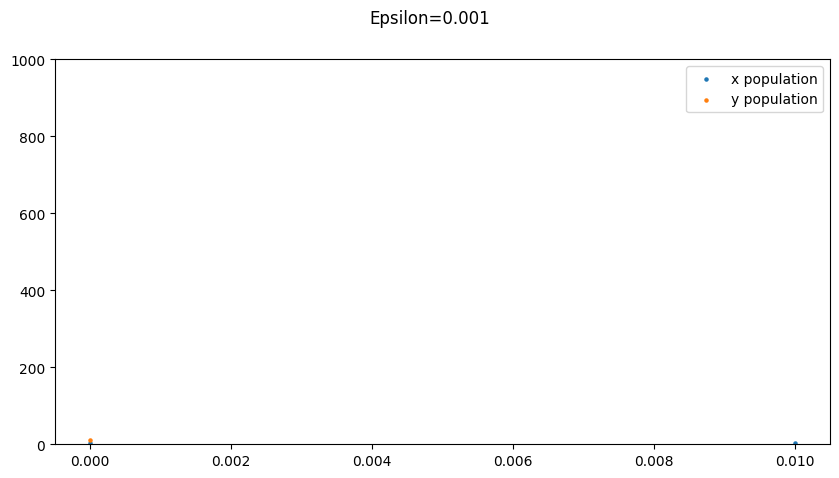

In [6]:
result_t, result_y = classicRK4(t_begin, y0, 0.01, f, t_end=t_end, e=Epsilon)
print(result_t, result_y)
drawResult(result_t, result_y, Epsilon)


## Неявный Рунге-Кутты

In [7]:
c = np.array([1/2 - np.sqrt(15)/10, 1/2, 1/2 + np.sqrt(15)/10])
A = np.array([
    [5/36, 2/9 - np.sqrt(15)/15, 5/36 - np.sqrt(15)/30],
    [5/36 + np.sqrt(15)/24, 2/9, 5/36 - np.sqrt(15)/24],
    [5/36 + np.sqrt(15)/30, 2/9 + np.sqrt(15)/15, 5/36]
])
b = np.array([5/18, 4/9, 5/18])

def implicitRK3(t0, y0, h, f, n_iter=None, t_end=None, e=None):
    if n_iter is None:
        n_iter = math.ceil((t_end - t0) / h)
    if e is None:
        e = Epsilon

    t = t0
    y = np.asarray(y0)
    m = y.size
    result_t = [t]
    result_y = [y.copy()]

    for _ in range(n_iter):
        def G(K_flat):
            K = K_flat.reshape((3, m))
            residuals = []
            for i in range(3):
                stage_sum = np.zeros(m)
                for j in range(3):
                    stage_sum += A[i, j] * K[j]
                fi = f(t + c[i] * h, y + h * stage_sum, e)
                residuals.append(K[i] - fi)
            return np.concatenate(residuals)

        K_flat_initial = np.tile(y, 3) 
        K_flat = op.fsolve(G, K_flat_initial)
        K = K_flat.reshape((3, m))

        y = y + h * (b @ K)
        t += h
        result_t.append(t)
        result_y.append(y.copy())

    return np.array(result_t), np.array(result_y)


/tmp/ipykernel_43677/1984206623.py:34: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  K_flat = op.fsolve(G, K_flat_initial)
/tmp/ipykernel_43677/1984206623.py:34: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last five Jacobian evaluations.
  K_flat = op.fsolve(G, K_flat_initial)
/tmp/ipykernel_43677/1984206623.py:34: RuntimeWarning: The number of calls to function has reached maxfev = 2600.
  K_flat = op.fsolve(G, K_flat_initial)


[0.000e+00 1.000e-01 2.000e-01 ... 2.998e+02 2.999e+02 3.000e+02] [[ 4.00000000e+000  1.00000000e+001  1.00000000e-003  1.00000000e+001]
 [ 3.24527067e+000 -2.20497603e+002  1.37510460e-002 -9.07366612e+000]
 [ 3.43638818e+000 -3.70718192e+003  1.62380492e-002  9.38780387e+000]
 ...
 [ 7.52971248e-282  8.28303024e-039 -1.21199611e+001 -1.41021655e+001]
 [ 6.63314261e-283  4.84888286e-040 -1.21197611e+001 -1.41019655e+001]
 [ 5.84356585e-284  2.83865350e-041 -1.21195611e+001 -1.41017655e+001]]


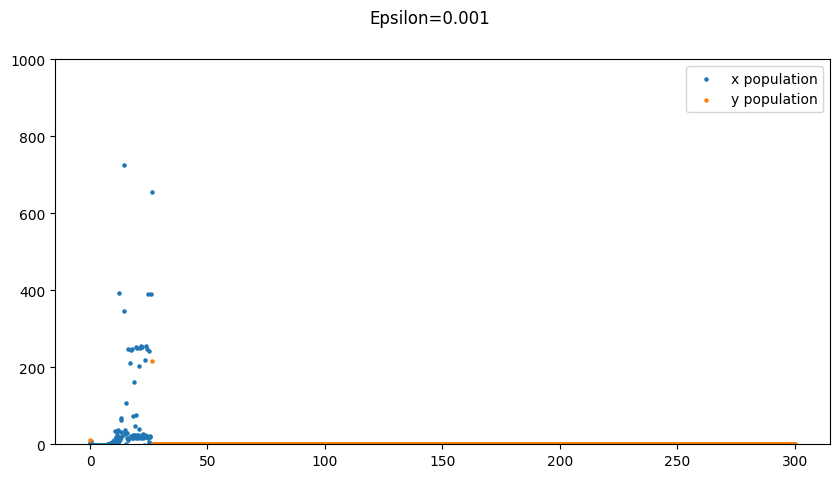

In [8]:
result_t, result_y = implicitRK3(t_begin, y0, 0.1, f, t_end=t_end, e=Epsilon)
print(result_t, result_y)

drawResult(result_t, result_y, Epsilon)


## Метод Адамса

In [9]:
def implicitAdams(t0, y0, h, f, order, n_iter=None, t_end=None):
    if n_iter is None:
        n_iter = math.ceil((t_end - t0) / h)
    if n_iter < order - 1:
        raise ValueError("n_iter must be at least order - 1")
        
    result_t, result_y = classicRK4(t0, y0, h, f, order - 1)
    result_t = list(result_t)
    result_y = list(result_y)
    
    denom = 24
    b = [9, 19, -5, 1]
    
    for i in range(order - 1, n_iter):
        t_new = result_t[-1] + h
        func = lambda Y: Y - result_y[-1] - h/denom * (
            b[0] * f(t_new, Y, Epsilon) +
            b[1] * f(result_t[-1], result_y[-1], Epsilon) +
            b[2] * f(result_t[-2], result_y[-2], Epsilon) +
            b[3] * f(result_t[-3], result_y[-3], Epsilon)
        )
        Y = fsolve(func, result_y[-1])
        result_t.append(t_new)
        result_y.append(Y)
        
    return np.array(result_t), np.array(result_y)

/tmp/ipykernel_43677/2224718477.py:9: RuntimeWarning: overflow encountered in scalar multiply
  y * (2*a2 - a1**(-3) * a2**3 * x - 0.5*y),
/tmp/ipykernel_43677/2224718477.py:8: RuntimeWarning: invalid value encountered in scalar multiply
  x * (2*a1 - 0.5*x - a1**3 * a2**(-3) * y),
/tmp/ipykernel_43677/2224718477.py:9: RuntimeWarning: overflow encountered in scalar power
  y * (2*a2 - a1**(-3) * a2**3 * x - 0.5*y),
/tmp/ipykernel_43677/2224718477.py:10: RuntimeWarning: invalid value encountered in scalar multiply
  e * (2 - 2*a1**2 * a2**(-3) * y),
/tmp/ipykernel_43677/2224718477.py:11: RuntimeWarning: overflow encountered in scalar power
  e * (2 - 2*a1**(-3) * a2**2 * x)
/tmp/ipykernel_43677/2706997051.py:22: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  Y = fsolve(func, result_y[-1])


[0.0000e+00 1.0000e-02 2.0000e-02 ... 2.9998e+02 2.9999e+02 3.0000e+02] [[ 4.00000000e+000  1.00000000e+001  1.00000000e-003  1.00000000e+001]
 [ 3.92164707e+000 -3.33033535e+227  1.02000000e-003 -1.04151177e+085]
 [             nan              nan              nan              nan]
 ...
 [             nan              nan              nan              nan]
 [             nan              nan              nan              nan]
 [             nan              nan              nan              nan]]


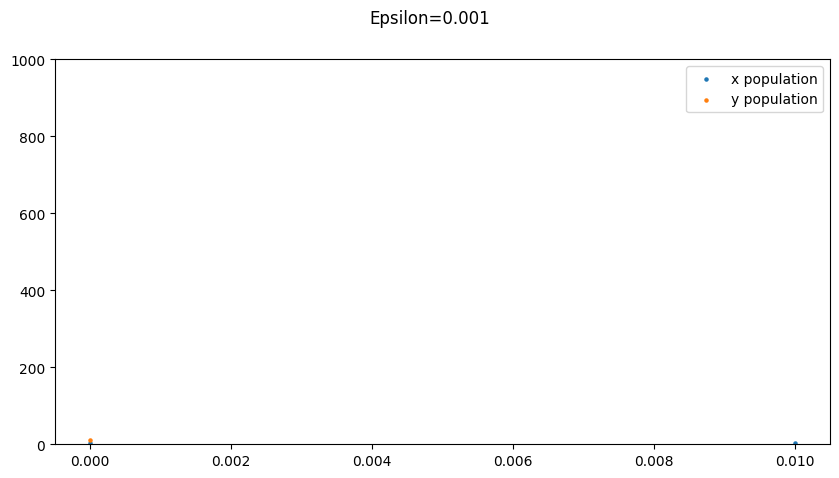

In [10]:
result_t, result_y = implicitAdams(t_begin, y0, 0.01, f, 4, t_end=t_end)
print(result_t, result_y)
drawResult(result_t, result_y, Epsilon)


## Метод Розенброка-Ваннера

In [11]:
def rosenbrockWanner3(t0, y0, h, f, n_iter=None, t_end=None, e=Epsilon):
    if n_iter is None:
        n_iter = math.ceil((t_end - t0) / h)
    result_t = [t0]
    result_y = [y0.copy()]
    
    t = t0
    y = y0.copy()
    gamma = 0.5
    
    for i in range(n_iter):
        J = getJacobi(lambda arg: f(t, arg, e), y, np.full_like(y0, 1e-6))
        I = np.eye(len(y))
        A = I - gamma * h * J
        
        k1 = np.linalg.solve(A, f(t, y, Epsilon))
        k2 = np.linalg.solve(A, f(t + 0.5 * h, y + 0.5 * k1, Epsilon) - k1)
        k3 = np.linalg.solve(A, f(t + h, y + 0.25 * k1 + 0.25 * k2, Epsilon) - 0.5 * k2)
    
        y = y + (1/6 * k1 + 2/3 * k2 + 1/6 * k3)
        t = t + h
        result_t.append(t)
        result_y.append(y.copy())
    
    return np.array(result_t), np.array(result_y)

/tmp/ipykernel_43677/2224718477.py:8: RuntimeWarning: overflow encountered in scalar multiply
  x * (2*a1 - 0.5*x - a1**3 * a2**(-3) * y),
/tmp/ipykernel_43677/2224718477.py:9: RuntimeWarning: overflow encountered in scalar multiply
  y * (2*a2 - a1**(-3) * a2**3 * x - 0.5*y),


[0.0000e+00 1.0000e-02 2.0000e-02 ... 2.9998e+02 2.9999e+02 3.0000e+02] [[ 4.00000000e+000  1.00000000e+001  1.00000000e-003  1.00000000e+001]
 [ 5.83758827e+000  2.90341757e+014 -2.83143583e+000 -1.38486644e+006]
 [-2.06256293e+000 -1.05066625e+123 -2.09728297e+035 -1.36125388e+041]
 ...
 [             nan              nan              nan              nan]
 [             nan              nan              nan              nan]
 [             nan              nan              nan              nan]]


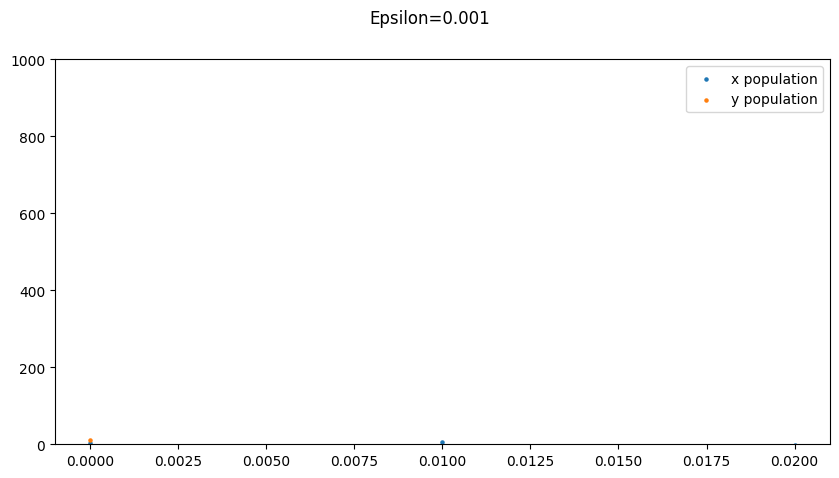

In [12]:
result_t, result_y = rosenbrockWanner3(t_begin, y0, 0.01, f, t_end=t_end)
print(result_t, result_y)
drawResult(result_t, result_y, Epsilon)